# Modelos para protease principal 3C-like protease (M<sup>pro</sup>) de SARS-CoV

Os modelos nesse fluxo de trabalho foram criados utilizando os decritores: 
 - PaDEL-Descriptor
 - Impressões digitais de Morgan
 - SiRMS (Simplex Representation of Molecular Structure) 
 - Drangon 7.0. 

E os algorítimos utilizando as bibliotecas da scikit-learn: 
 - Random Forest classifier
 - Support Vector Machine classifier 
 - Multi-layer Perceptron classifier. 

No total de 12 moledos criados com a combinação dos descritores e algorítimos: 
 - Random Forest
     - RF_Morgan
     - RF_SiRMS 
     - RF_Drangon
     - RF_PaDEL 
 - Support Vector Machine
     - SVM_Morgan 
     - SVM_SiRMS 
     - SVM_Drangon 
     - SVM_PaDEL 
   
 - Multi-layer Perceptron
     - MLP_Morgan
     - MLP_SiRMS
     - MLP_Drangon
     - MLP_PaDEL

## Importando Módulos e Funções

In [12]:
# Funções
from functions.BalanceBySim import *
from functions.DescritoresMorgan import morgan_descriptors
from functions.DescritoresPaDEL import padel_descriptors
from functions.DescritoresSiRMS import sirms_descriptors
from functions.DescritoresDragon import dragon_descriptors
from functions.stats import stats
from functions.RocAUC import roc_auc
from functions.YRandomization import y_randomization
from functions.BestModel import grid_search, random_search, best_grid_search, best_random_search
from functions.Evaluation import statistics
from functions.StatsChart import print_stats
from functions.CarregarDados import carregar_dados
from functions.Consenso import statistics_morganXpadel, statistics_sirmsXdragon
from functions.ConsensoChart import print_consenso
from functions.ComparisonHyperparameters import compare

# Algorítimos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#Ferramentas
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import gzip
import _pickle as cPickle
from scipy.stats import expon, randint, uniform
from pandas import DataFrame
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import PandasTools
from collections import Counter
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from sklearn.utils import resample
from rdkit.Chem import AllChem

## ETAPA 1 - Dados Biológicos (Y)

Original data:  (113, 11)
Dados mantidos:  (113, 11)
Forma do conjunto de treinamento:

		 Classe 1: 40
		 Classe 0: 73
		 Número total de compostos: 113
Class labels: [Counter({0: 73, 1: 40})]


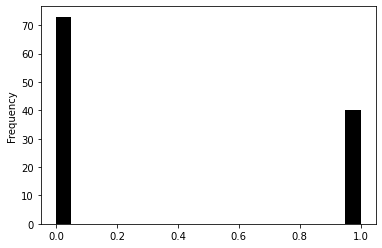

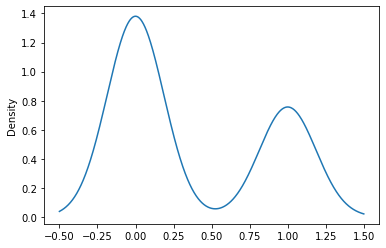

In [13]:
moldf = carregar_dados();
moldf.plot(kind="hist", legend=None, bins=20, color='k')
moldf.plot(kind="kde", legend=None);

## ETAPA 2 - Gerando Descritores (X)

#### Função Fingerprints de Harry Morgan

In [14]:
data_morgan = morgan_descriptors(moldf)
Y_train_morgan = data_morgan['Y_train']
X_train_morgan = data_morgan['X_train']
X_train_morgan.shape

Forma do conjunto de treinamento:

		 Classe 1: 40
		 Classe 0: 73
		 Número total de compostos: 113
Class labels: [Counter({0: 73, 1: 40})]
Forma do conjunto de treinamento: Counter({0: 73, 1: 40})
Forma externa definida: Counter()


(113, 2048)

#### PaDEL-Descriptor

In [15]:
data_padel = padel_descriptors(moldf)
Y_train_padel = data_padel['Y_train']
X_train_padel = data_padel['X_train']
X_train_padel.shape

Forma do conjunto de treinamento: Counter({0: 73, 1: 40})
Forma externa definida: Counter()


(113, 1444)

#### SiRMS (Simplex Representation of Molecular Structure)

In [16]:
data_sirms = sirms_descriptors(moldf)
Y_train_sirms = data_sirms['Y_train']
X_train_sirms = data_sirms['X_train']
X_train_sirms.shape

(113, 1261)

#### Drangon 7.0

In [21]:
data_dragon = dragon_descriptors(moldf)
Y_train_dragon = data_dragon['Y_train']
X_train_dragon = data_dragon['X_train']
X_train_dragon.shape

(113, 377)

#### Padronizando dados dos descritores

In [118]:
# Instancia o StandardScaler
scaler = StandardScaler()
minmax_df = MinMaxScaler()

X_train_scaled_morgan = scaler.fit_transform(X_train_morgan)
X_train_scaled_sirms = scaler.fit_transform(X_train_sirms)
X_train_scaled_dragon = scaler.fit_transform(X_train_dragon)
X_train_scaled_padel = scaler.fit_transform(X_train_padel)

X_train_minmax_morgan = minmax_df.fit_transform(X_train_morgan)
X_train_minmax_sirms = minmax_df.fit_transform(X_train_sirms)
X_train_minmax_dragon = minmax_df.fit_transform(X_train_dragon)
X_train_minmax_padel = minmax_df.fit_transform(X_train_padel)

#### Reamostragem dos dados p/ dados de teste

0    71
1    42
dtype: int64


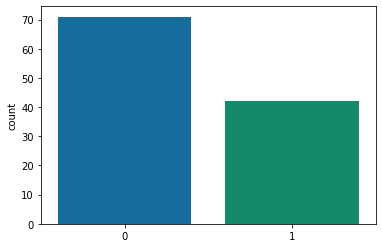

In [124]:
x_res_morgan, y_res_morgan = resample(X_train_scaled_morgan, Y_train_morgan, random_state=0)

# ver o balanceamento das classes
print(pd.Series(y_res_morgan).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_res_morgan);

 ## ETAPA 3 - Treinamento dos Modelos RF, SVM e MLP (Classificação)

### Otimização de Hiperparâmetros

#### Parâmetros Random Forest classifier

In [61]:
balance_data = 'no'
if balance_data == 'yes':
    class_weight = [None]
else:
    class_weight = [None,'balanced',
                    {0:.9, 1:.1}, {0:.8, 1:.2}, {0:.7, 1:.3}, {0:.6, 1:.4},
                    {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}]

# Grade de parametros
rf_param = {
    "n_estimators": [100, 250, 500, 750, 1000],
    "max_features": ['auto', 'sqrt'],
    "criterion": ['gini', 'entropy'],
    "random_state": [24],
    "class_weight": class_weight,
}

# Distribuição de parametros
rf_dist = {
    "n_estimators": randint(100,1000),
    "max_features": ['auto', 'sqrt'],
    "criterion": ['gini', 'entropy'],
    "random_state": [24],
    "class_weight": class_weight
}

#### Parâmetros Support Vector Machine classifier

In [62]:
# Grade de parametros
svm_param = {
    "C": [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "gamma": [0.1, 5, 10, 15, 20, 25, 30],
    "kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
    "random_state": [24]
}

# Distribuição de parametros
svm_dist = {
    "C": uniform(.001,100),
    "gamma": uniform(.1, 30),
    "kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
    "random_state": [24]
}

#### Parâmetros Multi-layer Perceptron classifier

In [63]:
# Grade de parametros
mpl_param = {
    'hidden_layer_sizes': [(100,600,1), (100,600,1), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.9],
    'learning_rate': ['constant','adaptive'],
}

# Distribuição de parametros
mpl_dist = {
    'hidden_layer_sizes': [(sp_randint.rvs(100,600,1),sp_randint.rvs(100,600,1),), 
                                          (sp_randint.rvs(100,600,1),)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': uniform(0.0001, 0.9),
    'learning_rate': ['constant','adaptive']
}

### Obtendo hiperparâmetros

#### Morgan

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
**Resultados Grid Search**
Melhores Parâmetros: {'class_weight': None, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 750, 'random_state': 24}
Melhor precisão de treinamento:	 0.8237154150197629
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'class_weight': None, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 683, 'random_state': 24}
Melhor precisão de treinamento:	 0.8237154150197629
Fitting 5 folds for each of 392 candidates, totalling 1960 fits
**Resultados Grid Search**
Melhores Parâmetros: {'C': 0.001, 'gamma': 5, 'kernel': 'poly', 'random_state': 24}
Melhor precisão de treinamento:	 0.8237154150197629
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'C': 44.346289377955664, 'gamma': 6.987316411894765, 'kernel': 'poly', 'random_state': 24}
Melhor precisão de trei

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**Resultados Grid Search**
Melhores Parâmetros: {'activation': 'logistic', 'alpha': 0.9, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Melhor precisão de treinamento:	 0.8154150197628459
Fitting 5 folds for each of 45 candidates, totalling 225 fits


C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**Resultados Random Search**
Melhores Parâmetros: {'activation': 'tanh', 'alpha': 0.21036027091790216, 'hidden_layer_sizes': (503,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Melhor precisão de treinamento:	 0.8237154150197629


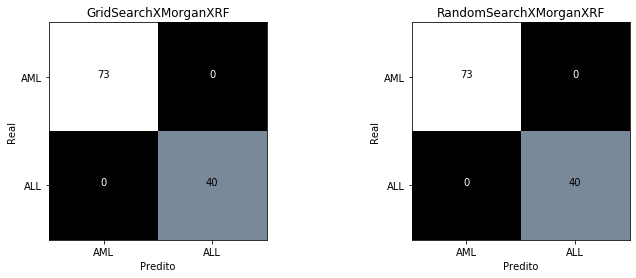

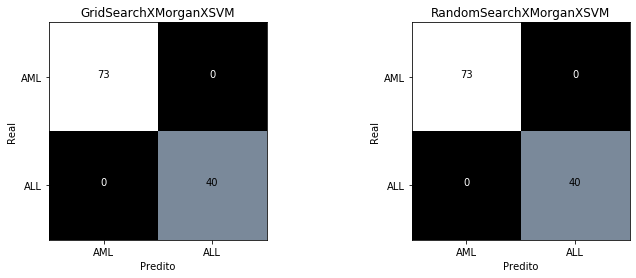

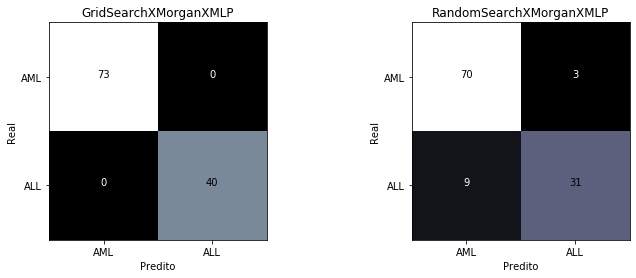

In [119]:
compare(RandomForestClassifier(), X_train_minmax_morgan, Y_train_morgan, rf_param, rf_dist, 'Morgan', 'RF')
compare(SVC(), X_train_minmax_morgan, Y_train_morgan, svm_param, svm_dist, 'Morgan', 'SVM')
compare(MLPClassifier(), X_train_minmax_morgan, Y_train_morgan, mpl_param, mpl_dist, 'Morgan', 'MLP')

#### Sirms

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
**Resultados Grid Search**
Melhores Parâmetros: {'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100, 'random_state': 24}
Melhor precisão de treinamento:	 0.7976284584980238
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'class_weight': {0: 0.6, 1: 0.4}, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 352, 'random_state': 24}
Melhor precisão de treinamento:	 0.7798418972332016
Fitting 5 folds for each of 392 candidates, totalling 1960 fits
**Resultados Grid Search**
Melhores Parâmetros: {'C': 0.01, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 24}
Melhor precisão de treinamento:	 0.7624505928853755
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'C': 44.346289377955664, 'gamma': 6.987316411894765, 'kernel': 'poly', 'random_state': 

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**Resultados Grid Search**
Melhores Parâmetros: {'activation': 'tanh', 'alpha': 0.9, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
Melhor precisão de treinamento:	 0.7798418972332016
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'activation': 'tanh', 'alpha': 0.21036027091790216, 'hidden_layer_sizes': (503,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Melhor precisão de treinamento:	 0.7798418972332016


C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


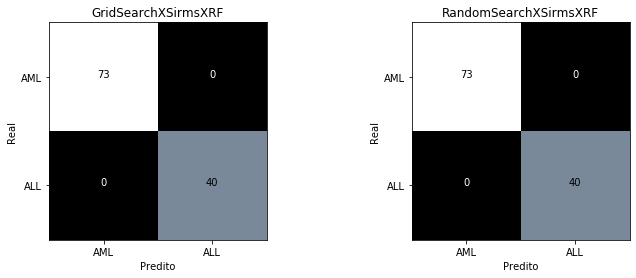

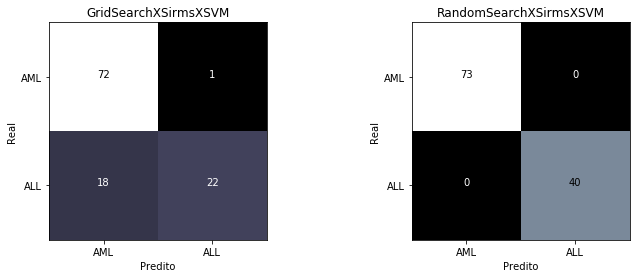

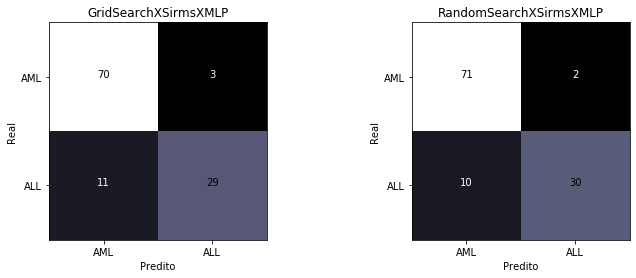

In [120]:
compare(RandomForestClassifier(), X_train_minmax_sirms, Y_train_sirms, rf_param, rf_dist, 'Sirms', 'RF')
compare(SVC(), X_train_minmax_sirms, Y_train_sirms, svm_param, svm_dist, 'Sirms', 'SVM')
compare(MLPClassifier(), X_train_minmax_sirms, Y_train_sirms, mpl_param, mpl_dist, 'Sirms', 'MLP')

#### Dragon

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
**Resultados Grid Search**
Melhores Parâmetros: {'class_weight': None, 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 250, 'random_state': 24}
Melhor precisão de treinamento:	 0.7711462450592885
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'class_weight': {0: 0.6, 1: 0.4}, 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 172, 'random_state': 24}
Melhor precisão de treinamento:	 0.7711462450592885
Fitting 5 folds for each of 392 candidates, totalling 1960 fits
**Resultados Grid Search**
Melhores Parâmetros: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 24}
Melhor precisão de treinamento:	 0.7885375494071147
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'C': 9.234859476879778, 'gamma': 5.687806341330127, 'kernel': 'linear', 'random_state': 24}
Melhor 

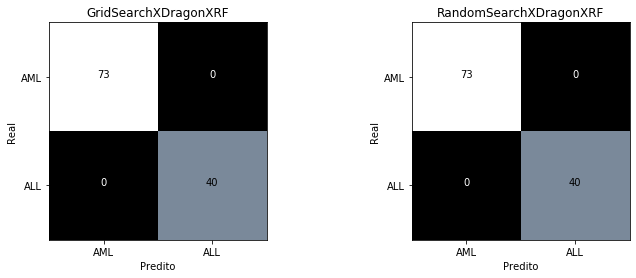

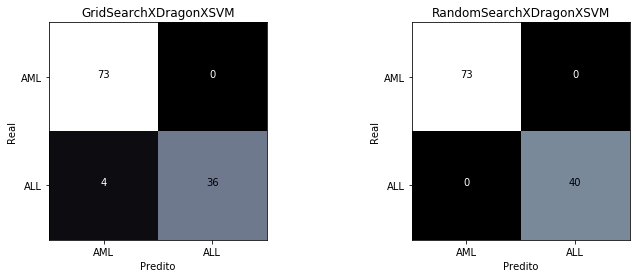

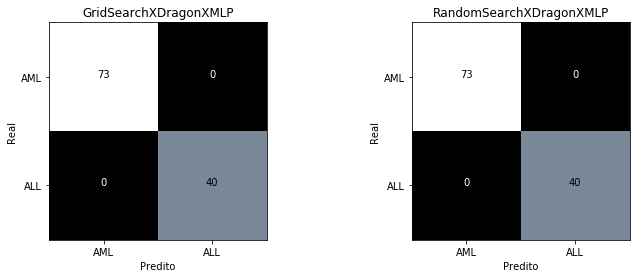

In [121]:
compare(RandomForestClassifier(), X_train_minmax_dragon, Y_train_dragon, rf_param, rf_dist, 'Dragon', 'RF')
compare(SVC(), X_train_minmax_dragon, Y_train_dragon, svm_param, svm_dist, 'Dragon', 'SVM')
compare(MLPClassifier(), X_train_minmax_dragon, Y_train_dragon, mpl_param, mpl_dist, 'Dragon', 'MLP')

#### Padel

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
**Resultados Grid Search**
Melhores Parâmetros: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 500, 'random_state': 24}
Melhor precisão de treinamento:	 0.7889328063241108
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 871, 'random_state': 24}
Melhor precisão de treinamento:	 0.7889328063241108
Fitting 5 folds for each of 392 candidates, totalling 1960 fits
**Resultados Grid Search**
Melhores Parâmetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 24}
Melhor precisão de treinamento:	 0.7529644268774703
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'C': 44.346289377955664, 'gamma': 6.987316411894765, 'kernel': 'poly', 'random_state': 24}
Melhor 

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**Resultados Grid Search**
Melhores Parâmetros: {'activation': 'relu', 'alpha': 0.9, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Melhor precisão de treinamento:	 0.7624505928853755
Fitting 5 folds for each of 45 candidates, totalling 225 fits
**Resultados Random Search**
Melhores Parâmetros: {'activation': 'relu', 'alpha': 0.8975663298449817, 'hidden_layer_sizes': (534, 571), 'learning_rate': 'adaptive', 'solver': 'adam'}
Melhor precisão de treinamento:	 0.7711462450592885


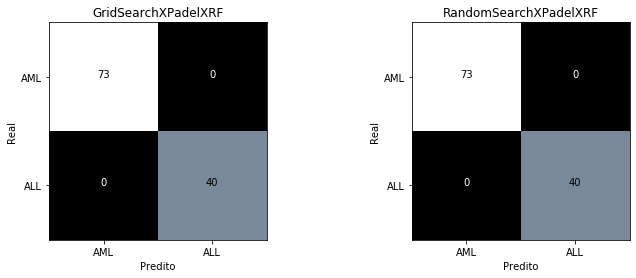

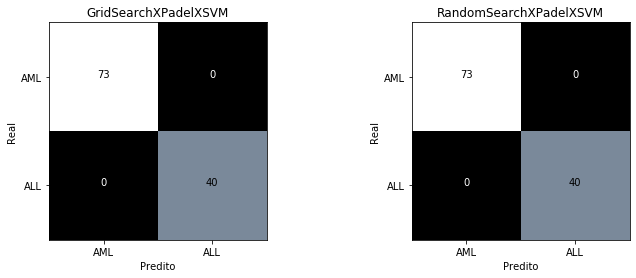

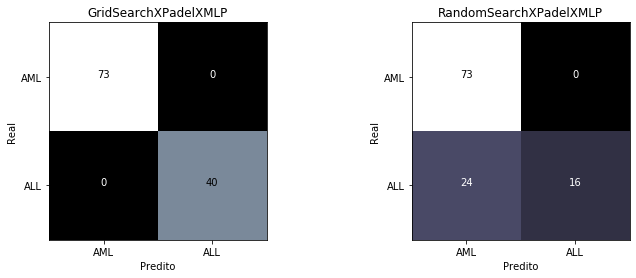

In [122]:
compare(RandomForestClassifier(), X_train_minmax_padel, Y_train_padel, rf_param, rf_dist, 'Padel', 'RF')
compare(SVC(), X_train_minmax_padel, Y_train_padel, svm_param, svm_dist, 'Padel', 'SVM')
compare(MLPClassifier(), X_train_minmax_padel, Y_train_padel, mpl_param, mpl_dist, 'Padel', 'MLP')

### Criando modelos a partir dos  melhores parâmetros

#### Melhores parâmetros Random Forest Classifier (Morgan, Sirms, Dragon e Padel)

In [125]:
#Criando o modelo com os melhores parametros utilizando processamento paralelo

# Morgan Melhores Parâmetros: {'class_weight': None, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 683, 'random_state': 24}
rf_best_morgan = RandomForestClassifier(class_weight=None, criterion='gini', max_features='sqrt', n_estimators=683, random_state=24,  n_jobs=-1)

# Sirms Melhores Parâmetros: {'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100, 'random_state': 24}
rf_best_sirms = RandomForestClassifier(class_weight={0: 0.7, 1: 0.3}, criterion='gini',max_features='auto', n_estimators=100, random_state=24, n_jobs=-1)

# Dragon Melhores Parâmetros: {'class_weight': {0: 0.6, 1: 0.4}, 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 172, 'random_state': 24}
rf_best_dragon = RandomForestClassifier(class_weight={0: 0.6, 1: 0.4},criterion='entropy', max_features='auto', n_estimators=172, random_state=24, n_jobs=-1)

# Padel Melhores Parâmetros: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 871, 'random_state': 24}
rf_best_padel = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_features='sqrt', n_estimators=871, random_state=24, n_jobs=-1)

#Construa uma floresta de árvores a partir do conjunto de treinamento (X, Y)
rf_best_morgan.fit(X_train_minmax_morgan, Y_train_morgan)
rf_best_sirms.fit(X_train_minmax_sirms, Y_train_sirms)
rf_best_dragon.fit(X_train_minmax_dragon, Y_train_dragon)
rf_best_padel.fit(X_train_minmax_padel, Y_train_padel)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='sqrt', n_estimators=871, n_jobs=-1,
                       random_state=24)

#### Melhores parâmetros Support Vector Machine classifier (Morgan, Sirms, Dragon e Padel)

In [126]:
#Criando o modelo com os melhores parametros utilizando processamento paralelo

# Morgan Melhores Parâmetros: {'C': 0.001, 'gamma': 5, 'kernel': 'poly', 'random_state': 24}
svm_best_morgan = SVC(C=0.001, gamma=5, random_state= 24, kernel='poly', probability=True)

# Sirms Melhores Parâmetros: {'C': 0.01, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 24}
svm_best_sirms = SVC(C=0.01, gamma=0.1, random_state= 24, kernel='linear', probability=True)

# Dragon Melhores Parâmetros: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 24}
svm_best_dragon = SVC(C=1, gamma=0.1, random_state= 24, kernel='rbf', probability=True)

# Padel {'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 24}
svm_best_padel = SVC(C=10, gamma=0.1, random_state= 24, kernel='rbf', probability=True)

#Construa vetores de suporte a partir do conjunto de treinamento (X, Y)
svm_best_morgan.fit(X_train_minmax_morgan, Y_train_morgan)
svm_best_sirms.fit(X_train_minmax_sirms, Y_train_sirms)
svm_best_dragon.fit(X_train_minmax_dragon, Y_train_dragon)
svm_best_padel.fit(X_train_minmax_padel, Y_train_padel)

SVC(C=10, gamma=0.1, probability=True, random_state=24)

#### Melhores parâmetros Parâmetros Multi-layer Perceptron classifier (Morgan, Sirms, Dragon e Padel)

In [127]:
#Criando o modelo com os melhores parametros utilizando processamento paralelo

# Morgan Melhores Parâmetros: {'activation': 'tanh', 'alpha': 0.21036027091790216, 'hidden_layer_sizes': (503,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
mlp_best_morgan = MLPClassifier(hidden_layer_sizes=(503,), activation = 'tanh', alpha= 0.21036027091790216, learning_rate = 'adaptive', solver = 'sgd')

# Sirms Melhores Parâmetros: {'activation': 'tanh', 'alpha': 0.9, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
mlp_best_sirms = MLPClassifier(hidden_layer_sizes=(100,), activation = 'tanh', alpha= 0.9, learning_rate = 'constant', solver = 'sgd')

# Dragon Melhores Parâmetros: {'activation': 'tanh', 'alpha': 0.7467430234547653, 'hidden_layer_sizes': (503,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
mlp_best_dragon = MLPClassifier(hidden_layer_sizes=(503,), activation = 'tanh', alpha= 0.7467430234547653, learning_rate = 'adaptive', solver = 'lbfgs')

# Padel {'activation': 'relu', 'alpha': 0.8975663298449817, 'hidden_layer_sizes': (534, 571), 'learning_rate': 'adaptive', 'solver': 'adam'}
mlp_best_padel = MLPClassifier(hidden_layer_sizes=(534, 571), activation = 'relu', alpha= 0.8975663298449817, learning_rate = 'adaptive', solver = 'adam')

#Construa camadas de neurônios conectadas a partir do conjunto de treinamento (X, Y)
mlp_best_morgan.fit(X_train_minmax_morgan, Y_train_morgan)
mlp_best_sirms.fit(X_train_minmax_sirms, Y_train_sirms)
mlp_best_dragon.fit(X_train_minmax_dragon, Y_train_dragon)
mlp_best_padel.fit(X_train_minmax_padel, Y_train_padel)

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(alpha=0.8975663298449817, hidden_layer_sizes=(534, 571),
              learning_rate='adaptive')

## ETAPA 4 - Validação dos modelos

###  Estatisiticas e AD - Random Forest Classifier (Morgan, Sirms, Dragon e Padel)

In [141]:
cross_val = StratifiedKFold(n_splits=5)

####  Trasformando em data set

In [142]:
ds_morgan = DataFrame(X_train_minmax_morgan)
ds_sirms = DataFrame(X_train_minmax_sirms)
ds_dragon = DataFrame(X_train_minmax_dragon)
ds_padel = DataFrame(X_train_minmax_padel)

In [143]:
rf_data_stats_morgan = statistics(rf_best_morgan, ds_morgan, Y_train_morgan, cross_val, data_morgan['moldf_desc'], data_morgan['moldf_train'], 'Morgan_RF')
rf_stats_morgan = rf_data_stats_morgan['stats']
rf_five_fold_morgan = rf_data_stats_morgan['five_fold']
rf_stats_morgan

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Morgan_RF,0.59,0.78,0.65,0.81,0.92,0.83,0.82,0.72,1.0
Morgan_RF AD,0.64,0.79,0.60,0.94,0.98,0.84,0.86,0.73,0.7


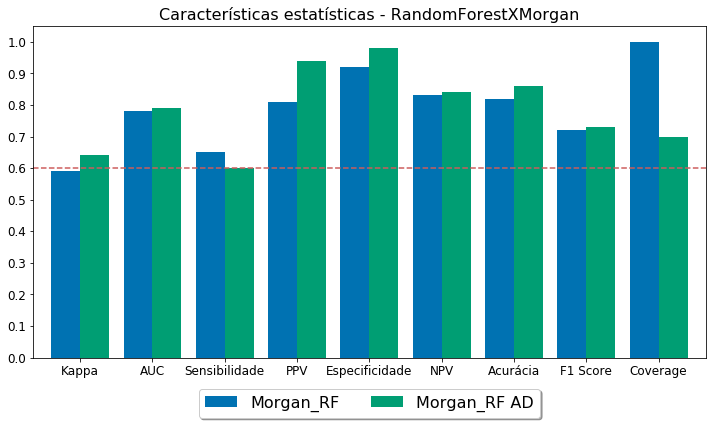

In [144]:
print_stats(rf_stats_morgan, 'Morgan', 'RandomForest')

In [145]:
rf_data_stats_sirms = statistics(rf_best_sirms, ds_sirms, Y_train_sirms, cross_val, data_sirms['moldf_desc'], data_sirms['moldf_train'], 'Sirms_RF')
rf_stats_sirms = rf_data_stats_sirms['stats']
rf_five_fold_sirms = rf_data_stats_sirms['five_fold']
rf_stats_sirms

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Sirms_RF,0.55,0.77,0.68,0.73,0.86,0.83,0.80,0.70,1.00
Sirms_RF AD,0.74,0.86,0.79,0.86,0.93,0.90,0.89,0.83,0.62


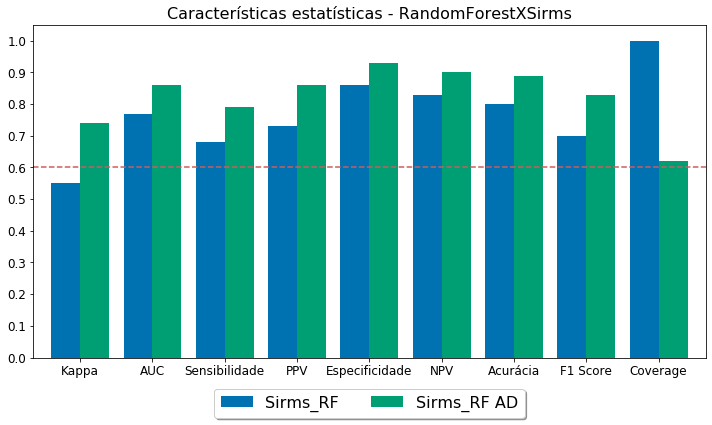

In [146]:
print_stats(rf_stats_sirms, 'Sirms', 'RandomForest')

In [147]:
rf_data_stats_dragon = statistics(rf_best_dragon, ds_dragon, Y_train_dragon, cross_val, data_dragon['moldf_desc'], data_dragon['moldf_train'], 'Dragon_RF')
rf_stats_dragon = rf_data_stats_dragon['stats']
rf_five_fold_dragon = rf_data_stats_dragon['five_fold']
rf_stats_dragon

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Dragon_RF,0.49,0.74,0.62,0.69,0.85,0.81,0.77,0.66,1.00
Dragon_RF AD,0.65,0.80,0.65,0.85,0.96,0.88,0.87,0.73,0.56


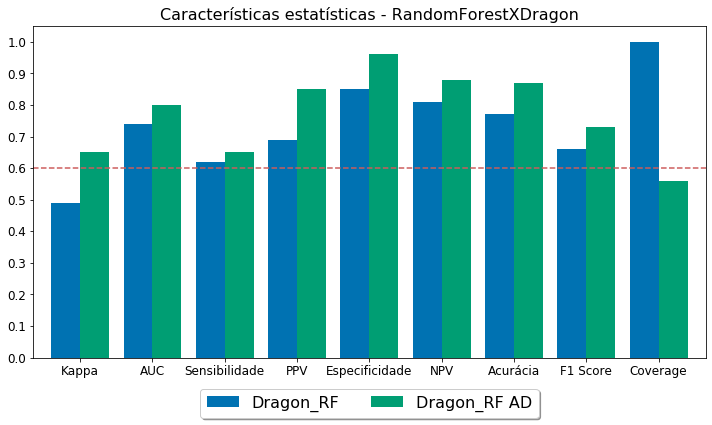

In [148]:
print_stats(rf_stats_dragon, 'Dragon', 'RandomForest')

In [149]:
rf_data_stats_padel = statistics(rf_best_padel, ds_padel, Y_train_padel, cross_val, data_padel['moldf_desc'], data_padel['moldf_train'], 'Padel_RF')
rf_stats_padel = rf_data_stats_padel['stats']
rf_five_fold_padel = rf_data_stats_padel['five_fold']
rf_stats_padel

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Padel_RF,0.51,0.75,0.60,0.75,0.89,0.80,0.79,0.67,1.00
Padel_RF AD,0.55,0.74,0.53,0.80,0.96,0.86,0.85,0.64,0.54


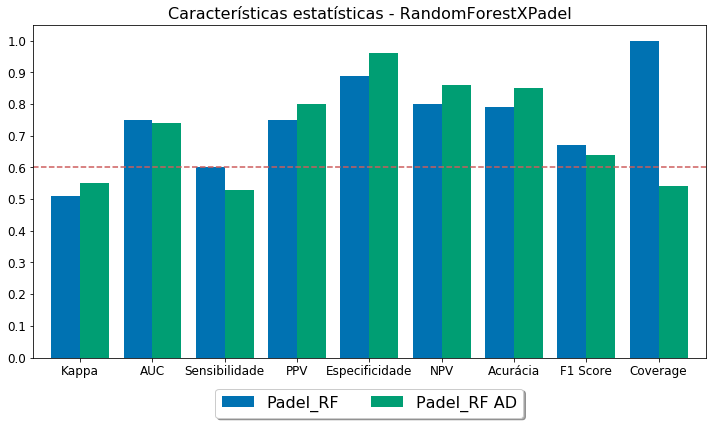

In [150]:
print_stats(rf_stats_padel, 'Padel', 'RandomForest')

###  Estatisiticas e AD - Support Vector Machine classifier (Morgan, Sirms, Dragon e Padel)

In [151]:
svm_data_stats_morgan = statistics(svm_best_morgan, ds_morgan, Y_train_morgan, cross_val, data_morgan['moldf_desc'], data_morgan['moldf_train'], 'Morgan_SVM')
svm_stats_morgan = svm_data_stats_morgan['stats']
svm_five_fold_morgan = svm_data_stats_morgan['five_fold']
svm_stats_morgan

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Morgan_SVM,0.59,0.78,0.65,0.81,0.92,0.83,0.82,0.72,1.00
Morgan_SVM AD,0.74,0.85,0.71,0.94,0.98,0.88,0.90,0.81,0.59


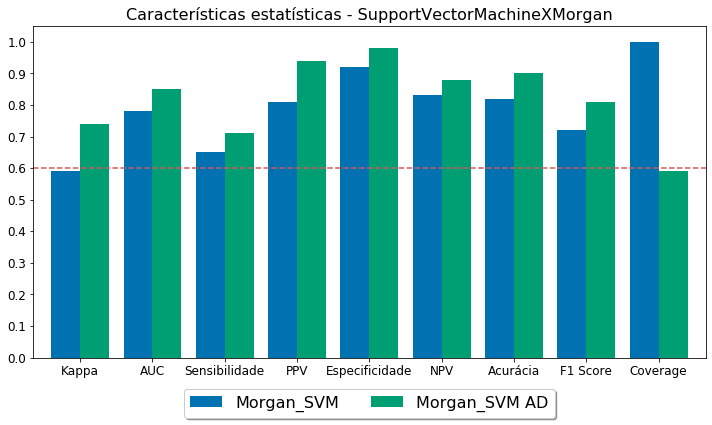

In [152]:
print_stats(svm_stats_morgan, 'Morgan', 'SupportVectorMachine')

In [153]:
svm_data_stats_sirms = statistics(svm_best_sirms, ds_sirms, Y_train_sirms, cross_val, data_sirms['moldf_desc'], data_sirms['moldf_train'], 'Sirms_SVM')
svm_stats_sirms = svm_data_stats_sirms['stats']
svm_five_fold_sirms = svm_data_stats_sirms['five_fold']
svm_stats_sirms

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Sirms_SVM,0.43,0.7,0.48,0.76,0.92,0.76,0.76,0.58,1.00
Sirms_SVM AD,0.61,0.8,0.70,0.76,0.90,0.87,0.84,0.73,0.66


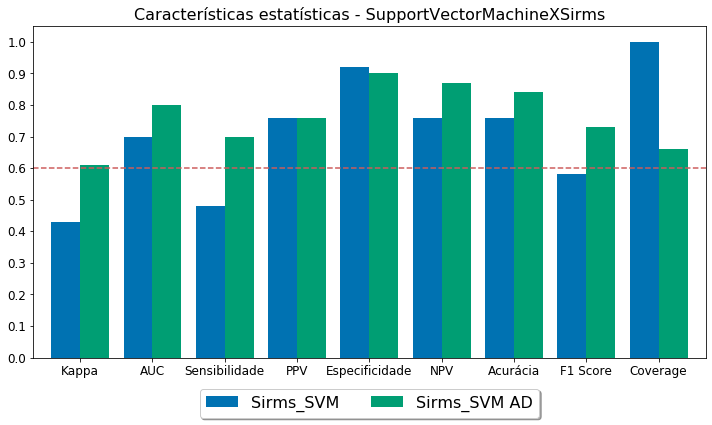

In [154]:
print_stats(svm_stats_sirms, 'Sirms', 'SupportVectorMachine')

In [155]:
svm_data_stats_dragon = statistics(svm_best_dragon, ds_dragon, Y_train_dragon, cross_val, data_dragon['moldf_desc'], data_dragon['moldf_train'], 'Dragon_SVM')
svm_stats_dragon = svm_data_stats_dragon['stats']
svm_five_fold_dragon = svm_data_stats_dragon['five_fold']
svm_stats_dragon

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Dragon_SVM,0.48,0.72,0.48,0.86,0.96,0.77,0.79,0.61,1.00
Dragon_SVM AD,0.63,0.78,0.56,1.00,1.00,0.82,0.85,0.72,0.65


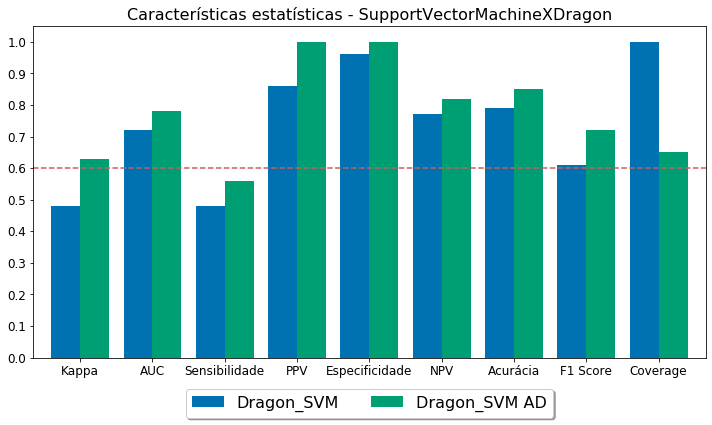

In [156]:
print_stats(svm_stats_dragon, 'Dragon', 'SupportVectorMachine')

In [157]:
svm_data_stats_padel = statistics(svm_best_padel, ds_padel, Y_train_padel, cross_val, data_padel['moldf_desc'], data_padel['moldf_train'], 'Padel_SVM')
svm_stats_padel = svm_data_stats_padel['stats']
svm_five_fold_padel = svm_data_stats_padel['five_fold']
svm_stats_padel

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Padel_SVM,0.36,0.66,0.32,0.93,0.99,0.73,0.75,0.48,1.00
Padel_SVM AD,0.69,0.81,0.65,0.92,0.98,0.88,0.89,0.76,0.55


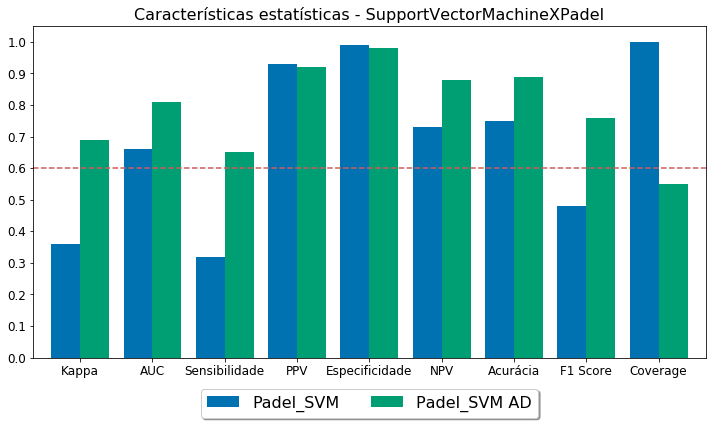

In [158]:
print_stats(svm_stats_padel, 'Padel', 'SupportVectorMachine')

###  Estatisiticas e AD - Multi-layer Perceptron classifier (Morgan, Sirms, Dragon e Padel)

In [159]:
mlp_data_stats_morgan = statistics(mlp_best_morgan, ds_morgan, Y_train_morgan, cross_val, data_morgan['moldf_desc'], data_morgan['moldf_train'], 'Morgan_MLP')
mlp_stats_morgan = mlp_data_stats_morgan['stats']
mlp_five_fold_morgan = mlp_data_stats_morgan['five_fold']
mlp_stats_morgan

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Morgan_MLP,0.48,0.73,0.60,0.71,0.86,0.80,0.77,0.65,1.00
Morgan_MLP AD,0.73,0.84,0.71,0.94,0.98,0.87,0.89,0.81,0.63


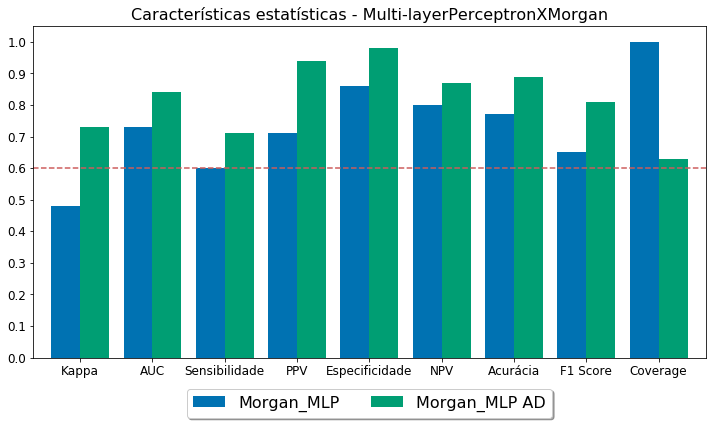

In [160]:
print_stats(mlp_stats_morgan, 'Morgan', 'Multi-layerPerceptron')

In [161]:
mlp_data_stats_sirms = statistics(mlp_best_sirms, ds_sirms, Y_train_sirms, cross_val, data_sirms['moldf_desc'], data_sirms['moldf_train'], 'Sirms_MLP')
mlp_stats_sirms = mlp_data_stats_sirms['stats']
mlp_five_fold_sirms = mlp_data_stats_sirms['five_fold']
mlp_stats_sirms

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Sirms_MLP,0.44,0.71,0.52,0.72,0.89,0.77,0.76,0.61,1.00
Sirms_MLP AD,0.63,0.80,0.67,0.80,0.93,0.88,0.86,0.73,0.57


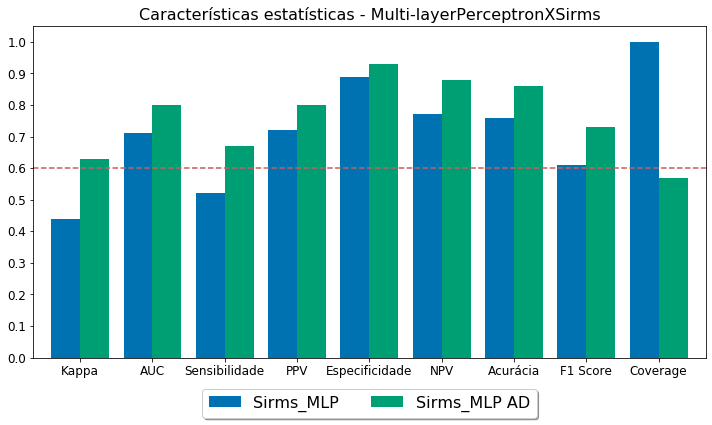

In [162]:
print_stats(mlp_stats_sirms, 'Sirms', 'Multi-layerPerceptron')

In [163]:
mlp_data_stats_dragon = statistics(mlp_best_dragon, ds_dragon, Y_train_dragon, cross_val, data_dragon['moldf_desc'], data_dragon['moldf_train'], 'Dragon_MLP')
mlp_stats_dragon = mlp_data_stats_dragon['stats']
mlp_five_fold_dragon = mlp_data_stats_dragon['five_fold']
mlp_stats_dragon

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Dragon_MLP,0.54,0.77,0.70,0.70,0.84,0.84,0.79,0.7,1.00
Dragon_MLP AD,0.53,0.76,0.69,0.71,0.84,0.83,0.78,0.7,0.86


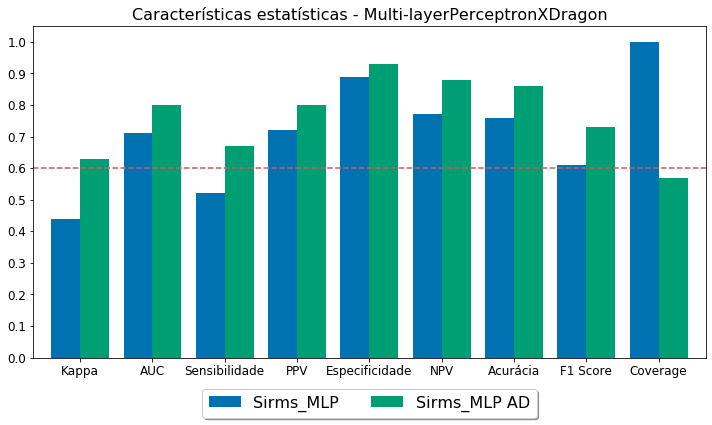

In [164]:
print_stats(mlp_stats_sirms, 'Dragon', 'Multi-layerPerceptron')

In [165]:
mlp_data_stats_padel = statistics(mlp_best_padel, ds_padel, Y_train_padel, cross_val, data_padel['moldf_desc'], data_padel['moldf_train'], 'Padel_MLP')
mlp_stats_padel = mlp_data_stats_padel['stats']
mlp_five_fold_padel = mlp_data_stats_padel['five_fold']
mlp_stats_padel

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Padel_MLP,0.43,0.72,0.68,0.61,0.77,0.81,0.73,0.64,1.00
Padel_MLP AD,0.58,0.79,0.72,0.74,0.85,0.84,0.80,0.73,0.86


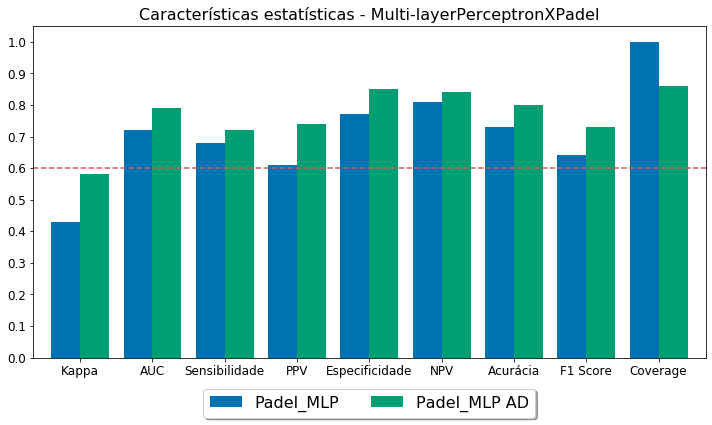

In [166]:
print_stats(mlp_stats_padel, 'Padel', 'Multi-layerPerceptron')

###  Concenso (Morgan)

In [167]:
concenso_morgan = VotingClassifier(estimators=[('rf', rf_best_morgan), ('svm', svm_best_morgan), ('mlp', mlp_best_morgan)], voting='soft')

concenso_data_stats_morgan = statistics(concenso_morgan, ds_morgan, Y_train_morgan, cross_val, data_morgan['moldf_desc'], data_morgan['moldf_train'], 'Morgan_Concenso')
concenso_stats_morgan = concenso_data_stats_morgan['stats']
concenso_five_fold_morgan = concenso_data_stats_morgan['five_fold']
concenso_stats_morgan

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Morgan_Concenso,0.60,0.79,0.68,0.79,0.90,0.84,0.82,0.73,1.00
Morgan_Concenso AD,0.72,0.83,0.68,0.94,0.98,0.88,0.89,0.79,0.65


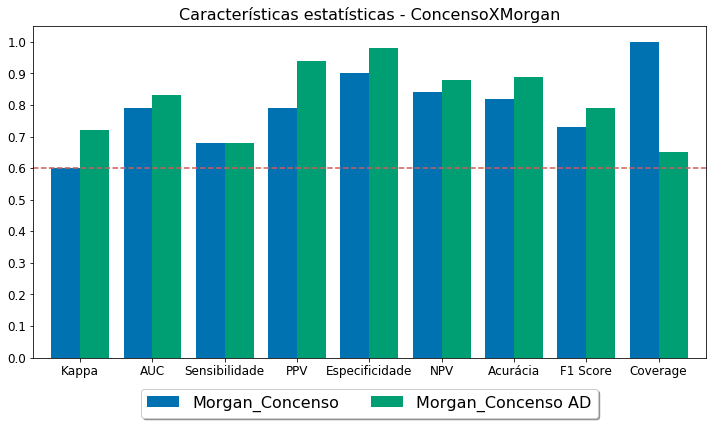

In [168]:
print_stats(concenso_stats_morgan, 'Morgan', 'Concenso')

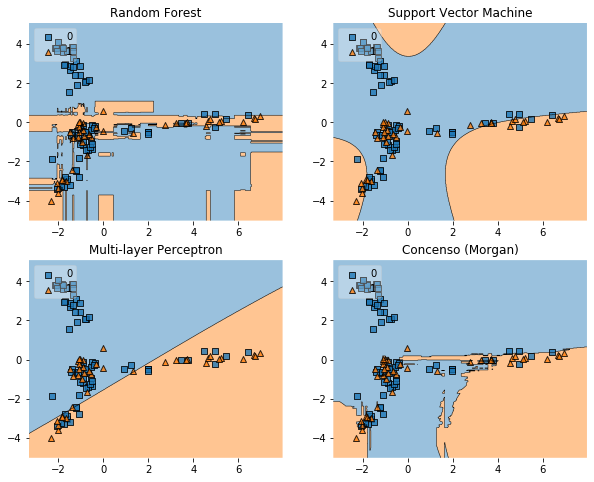

In [169]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

# reduzindo dados multidimensionais a dados bidimensionais.
pca = PCA(n_components = 2)
X = pca.fit_transform(ds_morgan)

y = Y_train_morgan

labels = ['Random Forest', 'Support Vector Machine', 'Multi-layer Perceptron', 'Concenso (Morgan)']
for clf, lab, grd in zip([rf_best_morgan, svm_best_morgan, mlp_best_morgan, concenso_morgan],
                         labels,
                         itertools.product([0, 1], repeat=2)):
    

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)

plt.show()

###  Concenso (Sirms)

In [170]:
concenso_sirms = VotingClassifier(estimators=[('rf', rf_best_sirms), ('svm', svm_best_sirms), ('mlp', mlp_best_sirms)], voting='soft')

concenso_data_stats_sirms = statistics(concenso_sirms, ds_sirms, Y_train_sirms, cross_val, data_sirms['moldf_desc'], data_sirms['moldf_train'], 'Sirms_Concenso')
concenso_stats_sirms = concenso_data_stats_sirms['stats']
concenso_five_fold_sirms = concenso_data_stats_sirms['five_fold']
concenso_stats_sirms

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Sirms_Concenso,0.49,0.73,0.57,0.74,0.89,0.79,0.78,0.65,1.00
Sirms_Concenso AD,0.70,0.84,0.74,0.85,0.94,0.89,0.88,0.79,0.65


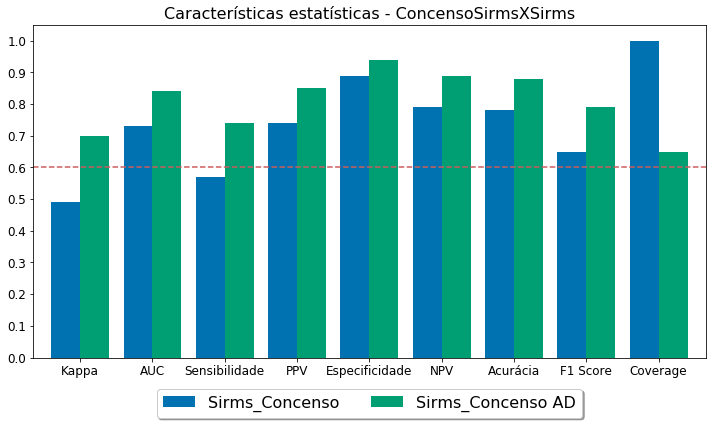

In [171]:
print_stats(concenso_stats_sirms, 'Sirms', 'ConcensoSirms')

C:\Users\Renata\anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:246: UserWarning: No contour levels were found within the data range.
  antialiased=True)


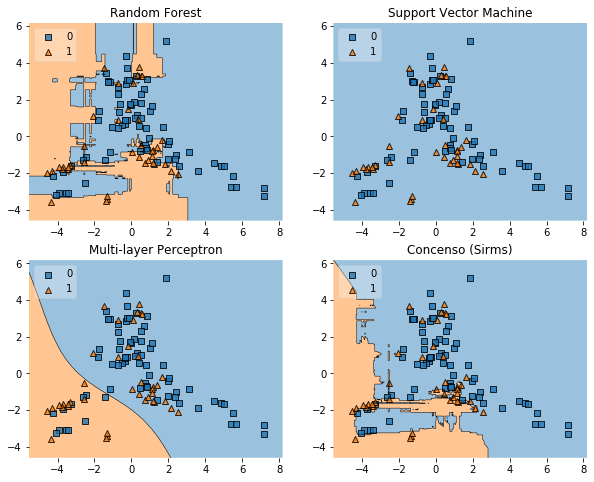

In [172]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

# reduzindo dados multidimensionais a dados bidimensionais.
pca = PCA(n_components = 2)
X = pca.fit_transform(ds_sirms)

y = Y_train_sirms

labels = ['Random Forest', 'Support Vector Machine', 'Multi-layer Perceptron', 'Concenso (Sirms)']
for clf, lab, grd in zip([rf_best_sirms, svm_best_sirms, mlp_best_sirms, concenso_sirms],
                         labels,
                         itertools.product([0, 1], repeat=2)):
    

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)

plt.show()

###  Concenso (Dragon)

In [173]:
concenso_dragon = VotingClassifier(estimators=[('rf', rf_best_dragon), ('svm', svm_best_dragon), ('mlp', mlp_best_dragon)], voting='soft')

concenso_data_stats_dragon = statistics(concenso_dragon, ds_dragon, Y_train_dragon, cross_val, data_dragon['moldf_desc'], data_dragon['moldf_train'], 'Dragon_Concenso')
concenso_stats_dragon = concenso_data_stats_dragon['stats']
concenso_five_fold_dragon = concenso_data_stats_dragon['five_fold']
concenso_stats_dragon

C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'False'] = np.nan
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_fold_descritor.AD[five_fold_descritor.AD == 'True'] = five_fold_descritor.Prediction


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Dragon_Concenso,0.45,0.72,0.62,0.66,0.82,0.80,0.75,0.64,1.00
Dragon_Concenso AD,0.67,0.81,0.62,1.00,1.00,0.83,0.86,0.76,0.65


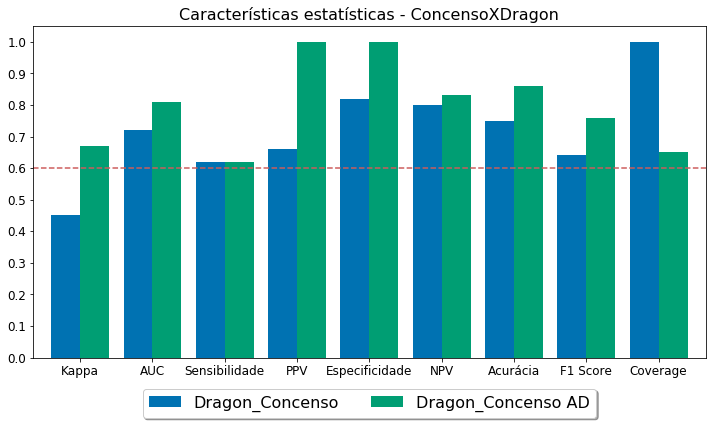

In [174]:
print_stats(concenso_stats_dragon, 'Dragon', 'Concenso')

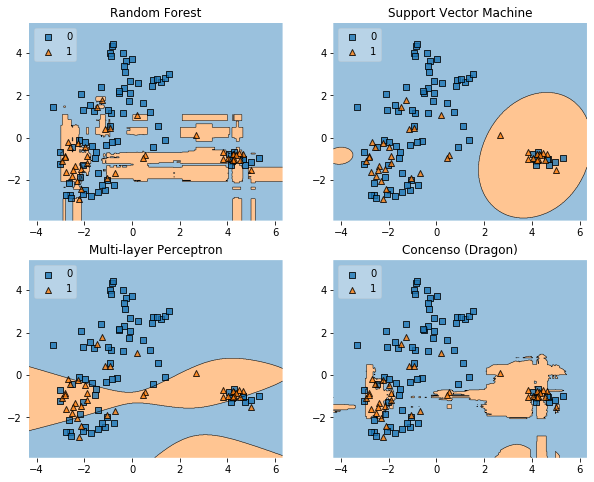

In [175]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

# reduzindo dados multidimensionais a dados bidimensionais.
pca = PCA(n_components = 2)
X = pca.fit_transform(ds_dragon)

y = Y_train_dragon

labels = ['Random Forest', 'Support Vector Machine', 'Multi-layer Perceptron', 'Concenso (Dragon)']
for clf, lab, grd in zip([rf_best_dragon, svm_best_dragon, mlp_best_dragon, concenso_dragon],
                         labels,
                         itertools.product([0, 1], repeat=2)):
    

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)

plt.show()

###  Concenso (Padel)

In [176]:
concenso_padel = VotingClassifier(estimators=[('rf', rf_best_padel), ('svm', svm_best_padel), ('mlp', mlp_best_padel)], voting='soft')

concenso_data_stats_padel = statistics(concenso_padel, ds_padel, Y_train_padel, cross_val, data_padel['moldf_desc'], data_padel['moldf_train'], 'Padel_Concenso')
concenso_stats_padel = concenso_data_stats_padel['stats']
concenso_five_fold_padel = concenso_data_stats_padel['five_fold']
concenso_stats_padel

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\Desktop\Pastas\PROJETO\procedimentos\functions\Evaluation.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
Padel_Concenso,0.41,0.69,0.52,0.68,0.86,0.77,0.74,0.59,1.00
Padel_Concenso AD,0.61,0.77,0.55,0.92,0.98,0.85,0.86,0.69,0.65


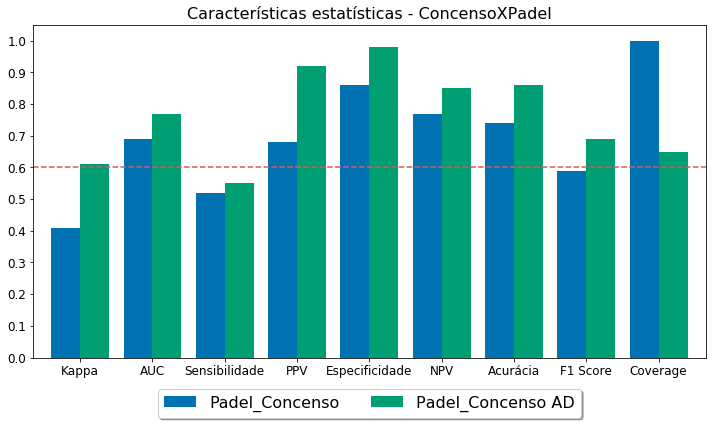

In [177]:
print_stats(concenso_stats_padel, 'Padel', 'Concenso')

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


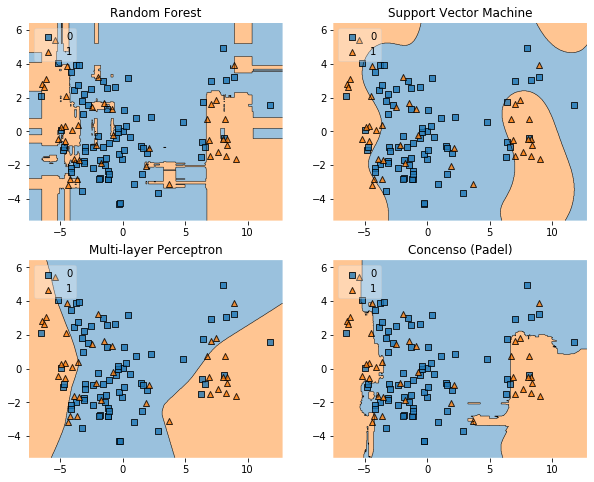

In [178]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

# reduzindo dados multidimensionais a dados bidimensionais.
pca = PCA(n_components = 2)
X = pca.fit_transform(ds_padel)

y = Y_train_padel

labels = ['Random Forest', 'Support Vector Machine', 'Multi-layer Perceptron', 'Concenso (Padel)']
for clf, lab, grd in zip([rf_best_padel, svm_best_padel, mlp_best_padel, concenso_padel],
                         labels,
                         itertools.product([0, 1], repeat=2)):
    

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)

plt.show()

#### Y-randomization - RF

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


True score =  0.78 
 Média per. =  0.5 
p-value =  0.0476


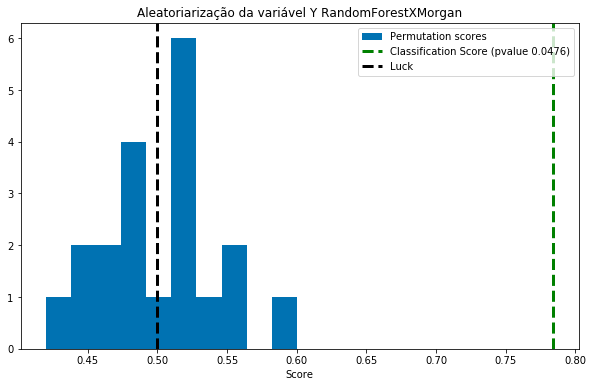

In [179]:
y_randomization(rf_best_morgan, ds_morgan, Y_train_morgan, 'Morgan', 'RandomForest')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.7s finished


True score =  0.77 
 Média per. =  0.49 
p-value =  0.0476


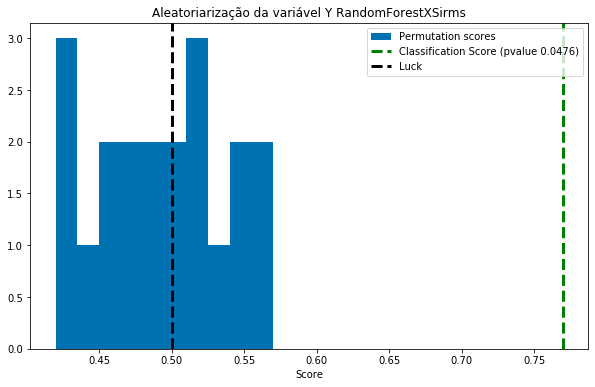

In [180]:
y_randomization(rf_best_sirms, ds_sirms, Y_train_sirms, 'Sirms', 'RandomForest')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.2s finished


True score =  0.74 
 Média per. =  0.51 
p-value =  0.0476


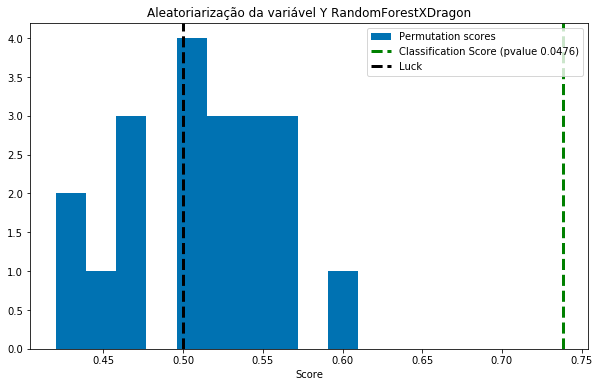

In [181]:
y_randomization(rf_best_dragon, ds_dragon, Y_train_dragon, 'Dragon', 'RandomForest')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished


True score =  0.75 
 Média per. =  0.5 
p-value =  0.0476


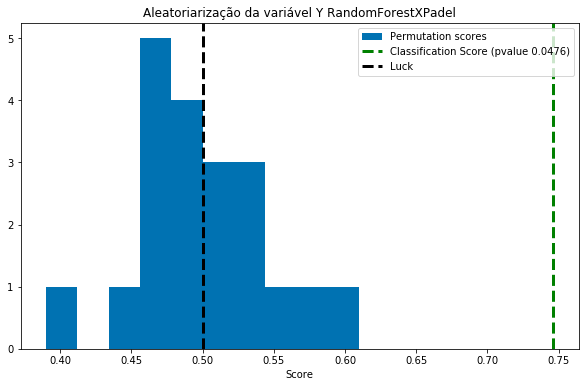

In [182]:
y_randomization(rf_best_padel, ds_padel, Y_train_padel, 'Padel', 'RandomForest')

#### Y-randomization - SVM

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.6s finished


True score =  0.78 
 Média per. =  0.51 
p-value =  0.0476


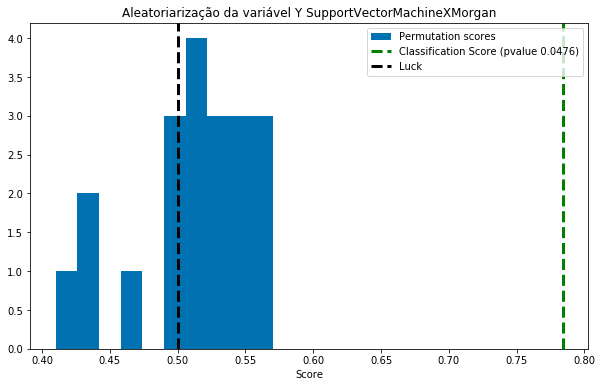

In [184]:
y_randomization(svm_best_morgan, ds_morgan, Y_train_morgan, 'Morgan', 'SupportVectorMachine')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished


True score =  0.7 
 Média per. =  0.5 
p-value =  0.0476


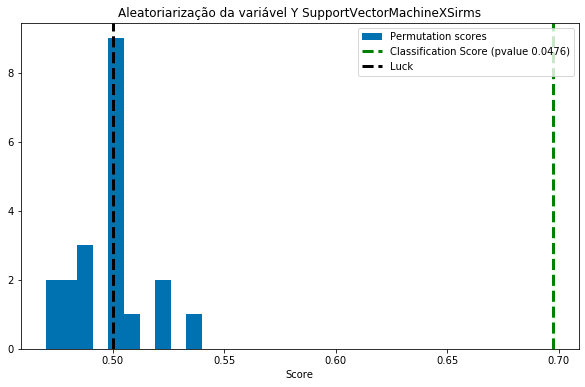

In [185]:
y_randomization(svm_best_sirms, ds_sirms, Y_train_sirms, 'Sirms', 'SupportVectorMachine')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished


True score =  0.72 
 Média per. =  0.49 
p-value =  0.0476


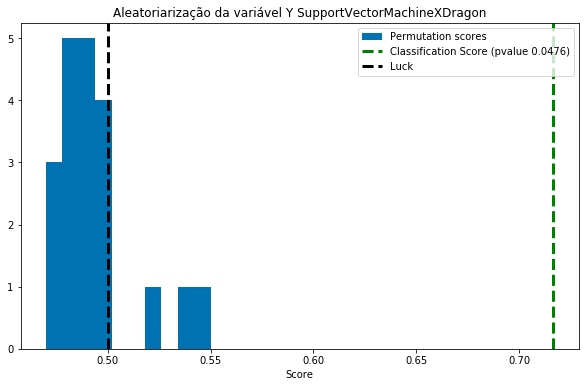

In [186]:
y_randomization(svm_best_dragon, ds_dragon, Y_train_dragon, 'Dragon', 'SupportVectorMachine')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s finished


True score =  0.66 
 Média per. =  0.5 
p-value =  0.0476


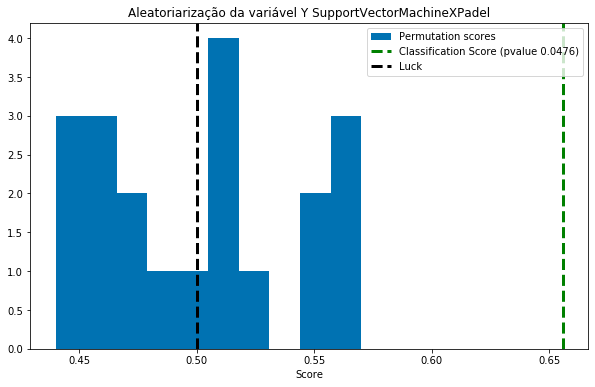

In [187]:
y_randomization(svm_best_padel, ds_padel, Y_train_padel, 'Padel', 'SupportVectorMachine')

#### Y-randomization - MLP

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

True score =  0.74 
 Média per. =  0.5 
p-value =  0.0476


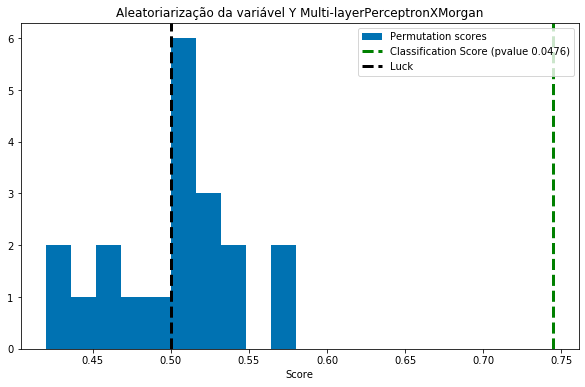

In [188]:
y_randomization(mlp_best_morgan, ds_morgan, Y_train_morgan, 'Morgan', 'Multi-layerPerceptron')

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

True score =  0.71 
 Média per. =  0.5 
p-value =  0.0476


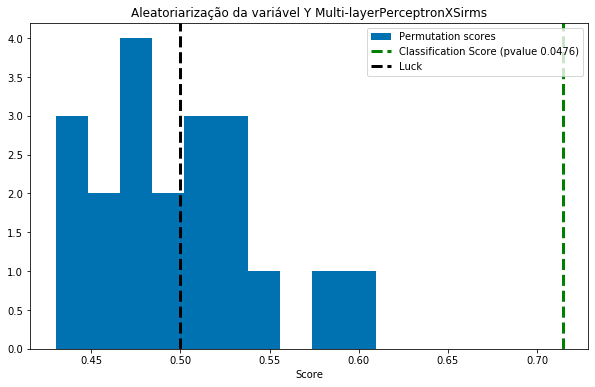

In [189]:
y_randomization(mlp_best_sirms, ds_sirms, Y_train_sirms, 'Sirms', 'Multi-layerPerceptron')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.1min finished


True score =  0.76 
 Média per. =  0.51 
p-value =  0.0476


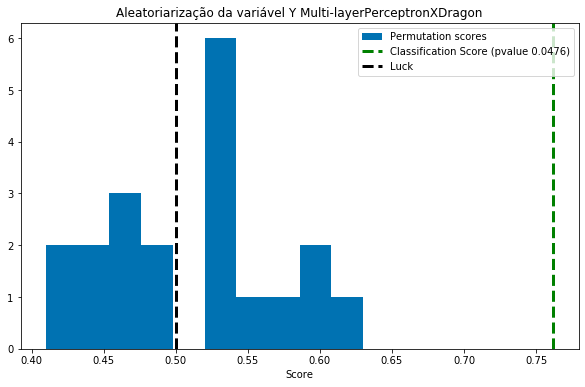

In [190]:
y_randomization(mlp_best_dragon, ds_dragon, Y_train_dragon, 'Dragon', 'Multi-layerPerceptron')

C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Renata\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 15.3min finished


True score =  0.71 
 Média per. =  0.49 
p-value =  0.0476


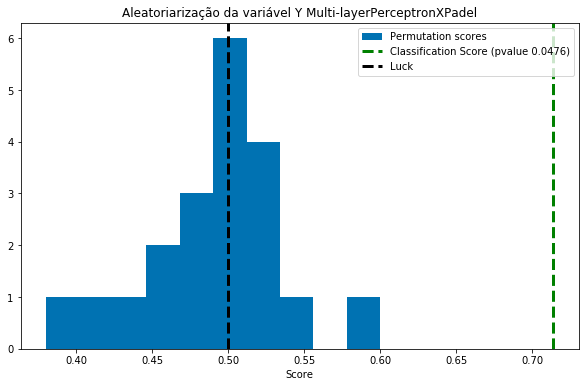

In [191]:
y_randomization(mlp_best_padel, ds_padel, Y_train_padel, 'Padel', 'Multi-layerPerceptron')

## ETAPA 5 - Virtual Screening

#### Importar dados de triagem (Drugbank)

In [194]:
# Set file path and format
file = './datasets/curated_data/drugbank.sdf.gz'

# Read SDF
sdfInfo = dict(molColName='ROMol', smilesName='SMILES')
moldf = PandasTools.LoadSDF(file, **sdfInfo);
#print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')

In [196]:
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)
from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

Kept data:  (9614, 7)

 Problematic structures: 
 []


#### Importar descriptores

In [199]:
# Morgan
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Sirms
train_desc_sirms = pd.read_csv('./descriptors/sirms-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t')
desc_list_sirms = train_desc_sirms.columns.tolist()

# Dragon
train_desc_dragon = pd.read_csv('./descriptors/dragon-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t')
desc_list_dragon = train_desc_dragon.columns.tolist()

# Padel
train_desc_padel = pd.read_csv('./descriptors/descritores_padel.csv', sep=',')
desc_list_padel = train_desc_padel.columns.tolist()

#### Importar descriptor da VS

##### Importar descriptor morgan-drugbank

In [203]:
X_vs = moldf.Mol.apply(calcfp)
X_vs.shape

(9614, 2048)

##### Importar descriptor sirms-drugbank

In [201]:
vs_desc = pd.read_csv('./descriptors/sirms-drugbank.csv.gz', sep='\t')
vs_desc.head()

,Fr1(chg)/A,Fr1(chg)/B,Fr1(chg)/C,Fr1(chg)/D,Fr2(chg)/A_A/1_2a/,Fr2(chg)/A_A/1_2d/,Fr2(chg)/A_A/1_2s/,Fr2(chg)/A_A/1_2t/,Fr2(chg)/A_B/1_2a/,Fr2(chg)/A_B/1_2d/,...,"S_A(chg)/D_D_D_D/1_3a,2_4a,3_4a/6","S_A(chg)/D_D_D_D/1_3s,2_3s,3_4d/5","S_A(chg)/D_D_D_D/1_3s,2_4s,3_4a/6","S_A(chg)/D_D_D_D/1_3s,2_4s,3_4d/6","S_A(chg)/D_D_D_D/1_3s,2_4s,3_4s/6","S_A(chg)/D_D_D_D/1_4s,2_4s,3_4s/5","S_A(chg)/D_D_D_D/2_3s,3_4a/4","S_A(chg)/D_D_D_D/2_3s,3_4d/4","S_A(chg)/D_D_D_D/2_4a,3_4a/4","S_A(chg)/D_D_D_D/2_4s,3_4s/4"
0,11,6,18,13,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,0
1,6,7,29,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,14,25,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,8,8,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,14
4,4,6,15,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Importar descriptor dragon-drugbank

In [202]:
train_desc = pd.read_csv('./descriptors/dragon-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t')
desc_list = train_desc.columns.tolist()
train_desc.head()

,AECC,ALOGP,ALOGP2,AMW,ATS4m,ATSC1s,ATSC3e,B01[C-Cl],B01[C-S],B01[N-O],...,nCconj,nCrs,nCrt,nCsp2,nR06,nR=Cs,nRCONR2,nRCOOR,nThiophenes,piPC08
0,14.718,-1.294,1.675,6.897,4.419,26.457,1.207,0,0,0,...,0,0,0,9,0,0,0,0,0,4.953
1,10.789,3.748,14.050,7.263,4.435,12.193,0.642,0,0,0,...,0,0,0,19,2,0,1,0,0,7.126
2,14.514,0.317,0.100,6.864,4.317,26.744,1.050,0,0,1,...,1,0,0,9,0,0,0,0,0,4.894
3,12.187,4.107,16.863,7.143,3.955,12.555,0.391,0,0,0,...,3,0,0,22,3,2,0,0,0,5.923
4,14.800,-3.732,13.929,7.695,4.561,78.238,1.917,0,0,0,...,0,0,0,14,1,0,0,0,0,5.424


### Consenso por descritores

#### Obter consenso  - Random Forest Classifier (Morgan, Sirms, Dragon e Padel)

In [ ]:
pred_rf_morgan = rf_best_morgan.predict(x_ts)
pred_rf_sirms = rf_best_sirms.predict(x_ts)
pred_rf_dragon = rf_best_dragon.predict(x_ts)
pred_rf_padel = rf_best_padel.predict(x_ts)

pred_rf = 1 * (((pred_rf_morgan + pred_rf_sirms + pred_rf_dragon + pred_rf_padel) / 4) >= 0.5)

# calc statistics
print("Accuracy = ", accuracy_score(Y_train_padel, pred_rf))
print("MCC = ", matthews_corrcoef(Y_train_padel, pred_rf))
print("Kappa = ", cohen_kappa_score(Y_train_padel, pred_rf))

#### Obter consenso  - Support Vector Machine classifier (Morgan, Sirms, Dragon e Padel)

In [ ]:
pred_svm_morgan = svm_best_morgan.predict(x_ts)
pred_svm_sirms = svm_best_sirms.predict(x_ts)
pred_svm_dragon = svm_best_dragon.predict(x_ts)
pred_svm_padel = svm_best_padel.predict(x_ts)

pred_svm = 1 * (((pred_svm_morgan + pred_svm_sirms + pred_svm_dragon + pred_svm_padel) / 4) >= 0.5)

# calc statistics
print("Accuracy = ", accuracy_score(Y_train_padel, pred_svm))
print("MCC = ", matthews_corrcoef(Y_train_padel, pred_svm))
print("Kappa = ", cohen_kappa_score(Y_train_padel, pred_svm))

#### Obter consenso  - Multi-layer Perceptron classifier (Morgan, Sirms, Dragon e Padel)

In [ ]:
pred_mlp_morgan = mlp_best_morgan.predict(x_ts)
pred_mlp_sirms = mlp_best_sirms.predict(x_ts)
pred_mlp_dragon = mlp_best_dragon.predict(x_ts)
pred_mlp_padel = mlp_best_padel.predict(x_ts)

pred_mlp = 1 * (((pred_mlp_morgan + pred_mlp_sirms + pred_mlp_dragon + pred_mlp_padel) / 4) >= 0.5)

# calc statistics
print("Accuracy = ", accuracy_score(Y_train_padel, pred_mlp))
print("MCC = ", matthews_corrcoef(Y_train_padel, pred_mlp))
print("Kappa = ", cohen_kappa_score(Y_train_padel, pred_mlp))

#### Plotar consenso  - Random Forest Classifier (Morgan, Sirms, Dragon e Padel)

In [ ]:
print_consenso(stats_morganXpadel, 'Random Forest','MorganXPadel')

In [ ]:
print_consenso(stats_sirmsXdragon, 'Random Forest','SirmsXDragon')

## Salvar modelos

In [ ]:
with gzip.GzipFile('model/sars-cov-3clpro-morgan_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best_morgan, f)
with gzip.GzipFile('model/sars-cov-3clpro-sirms_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best_sirms, f)
with gzip.GzipFile('model/sars-cov-3clpro-dragon_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best_dragon, f)
with gzip.GzipFile('model/sars-cov-3clpro-padel_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best_padel, f)